# Name : Fernando I.A.M.D.
# Index No.: 190172K

In [2]:
import cv2
import numpy as np
import sympy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy . optimize import minimize
from scipy import linalg
from numpy.linalg import inv
%matplotlib inline

## Q1

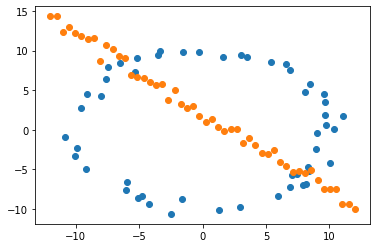

In [4]:

# np . random . seed ( 0 )
N = 100
half_n = N//2
r = 10
s = r/16
t = np . random . uniform ( 0 , 2*np . pi , half_n )
n = s *np . random . randn ( half_n )
x , y = ( r + n ) * np . cos ( t ) , ( r + n ) * np . sin ( t )
plt.scatter(x,y)
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b = -1, 2
x = np . linspace ( -12 , 12 , half_n )
y = m*x + b + s *np . random . randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )

plt.scatter(x,y)
plt.show()

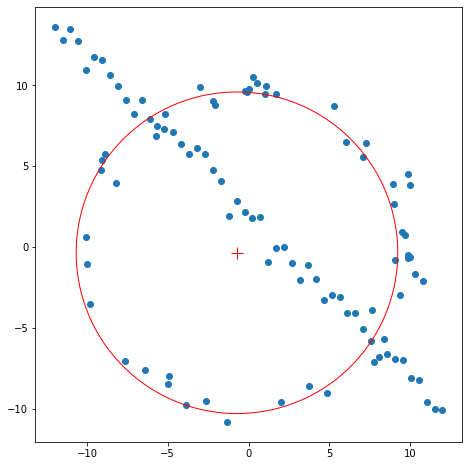

In [3]:
def generate_data():
	X_data, Y_data = [],[]
	N = 100
	half_n = N // 2
	r = 10
	s = r/16
	t = np.random.uniform(0 , 2*np.pi , half_n )
	n = s*np.random.randn(half_n)
	x , y = (r+n)*np.cos(t),(r + n)*np.sin(t)
	X_circ = np.hstack((x.reshape(half_n , 1 ) , y.reshape( half_n , 1 ) ) )
	m, b = -1, 2
	x = np.linspace(-12, 12 , half_n )
	y = m*x + b + s*np.random.randn( half_n )
	X_line = np.hstack((x.reshape( half_n , 1 ) , y.reshape( half_n , 1 ) ) )
	X = np.vstack(( X_circ , X_line ) )

	for vals in X:
		X_data.append(vals[0])
		Y_data.append(vals[1])

	return X_data, Y_data


class RANSAC:
	def __init__(self, x_data, y_data, n):
		self.x_data = x_data
		self.y_data = y_data
		self.n = n
		self.d_min = 99999
		self.best_model = None

	def random_sampling(self):
		sample = []
		save_ran = []
		count = 0

		# get three points from data
		while True:
			ran = np.random.randint(len(self.x_data))

			if ran not in save_ran:
				sample.append((self.x_data[ran], self.y_data[ran]))
				save_ran.append(ran)
				count += 1

				if count == 3:
					break

		return sample

	def make_model(self, sample):	
		pt1 = sample[0]
		pt2 = sample[1]
		pt3 = sample[2]

		A = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]]) 
		B = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])		
		inv_A = inv(A)

		c_x, c_y = np.dot(inv_A, B) / 2
		c_x, c_y = c_x[0], c_y[0]
		r = np.sqrt((c_x - pt1[0])**2 + (c_y - pt1[1])**2)

		return c_x, c_y, r

	def eval_model(self, model):
		d = 0
		c_x, c_y, r = model

		for i in range(len(self.x_data)):
			dis = np.sqrt((self.x_data[i]-c_x)**2 + (self.y_data[i]-c_y)**2)

			if dis >= r:
				d += dis - r
			else:
				d += r - dis
		
		return d

	def execute_ransac(self):
		for i in range(self.n):
			model = self.make_model(self.random_sampling())
			d_temp = self.eval_model(model)
			
			if self.d_min > d_temp:
				self.best_model = model
				self.d_min = d_temp


if __name__ == '__main__':
	x_data, y_data = generate_data()

	plt.figure(figsize=(8, 8))
	plt.scatter(x_data, y_data, marker='o', label='data')

	ransac = RANSAC(x_data, y_data, 50)

	ransac.execute_ransac()

	a, b, r = ransac.best_model[0], ransac.best_model[1], ransac.best_model[2]

	circle = plt.Circle((a, b), radius=r, color='r', fc='y', fill=False)
	plt.gca().add_patch(circle)
	plt.plot(a, b, 'r', marker='+', markersize=12)
	plt.axis('scaled')
	plt.show()

## Q2

(84, 492, 3)


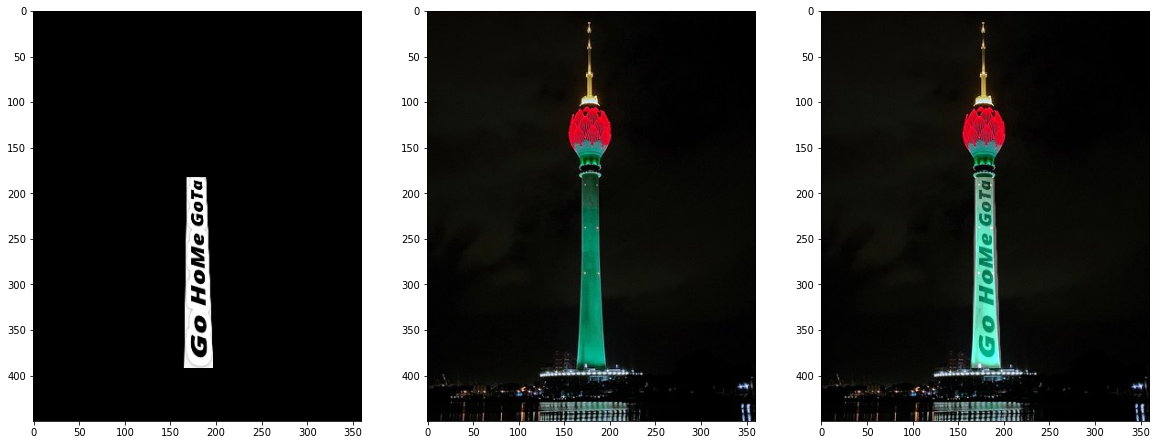

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

N = 4
global n
n = 0
pts_src = np.empty((N, 2))
pts_dst = np.empty((N, 2))

def draw_circle(event, x, y, flags, param):
    global n
    p = param[0]
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(param[1], (x, y), 5, (255, 0, 0), -1)
        p[n] = (x, y)
        n += 1

im_src = cv2.imread('1.jpg')
print(im_src.shape)
pts_src = np.array([[0, 0], [0,84], [492, 0],[492, 84]])

im_dst = cv2.imread('towering-at-an-imposing.jpg')

im_dst_copy = im_dst.copy()
param = [pts_dst, im_dst_copy]
cv2.namedWindow("Select Points", cv2.WINDOW_AUTOSIZE)
cv2.setMouseCallback('Select Points', draw_circle, param)

while (1):
    cv2.imshow("Select Points", im_dst_copy)
    if n == N:
        break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

h, status = cv2.findHomography(pts_src, pts_dst)
im_out = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))

im_out1 = cv2.addWeighted(im_dst,1,im_out,.4,0)

fig, ax = plt.subplots(1,3,figsize= (20,10))

ax[0].imshow(cv2.cvtColor(im_out, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(im_dst, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(im_out1, cv2.COLOR_BGR2RGB))
plt.show()

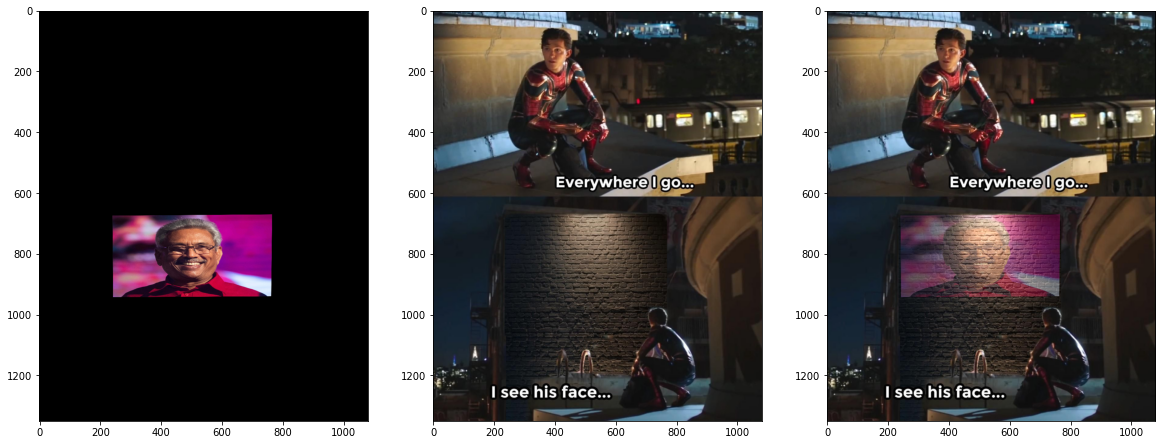

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

N = 4
global n
n = 0
pts_src = np.empty((N, 2))
pts_dst = np.empty((N, 2))

def draw_circle(event, x, y, flags, param):
    global n
    p = param[0]
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(param[1], (x, y), 5, (255, 0, 0), -1)
        p[n] = (x, y)
        n += 1

im_src = cv2.imread('gotabaya-rajapaksa-controversial-war-hero-who-ended-sri-lankas-3-decade-long-bloody-civil-conflict.jpg')
pts_src = np.array([[0, 0], [1200,0], [0, 900],[1200, 900]])

im_dst = cv2.imread('0542a568280eaff0cd2dfadbfa362ecd.jpg')

im_dst_copy = im_dst.copy()
param = [pts_dst, im_dst_copy]
cv2.namedWindow("Select Points", cv2.WINDOW_AUTOSIZE)
cv2.setMouseCallback('Select Points', draw_circle, param)

while (1):
    cv2.imshow("Select Points", im_dst_copy)
    if n == N:
        break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

h, status = cv2.findHomography(pts_src, pts_dst)
im_out = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))

im_out1 = cv2.addWeighted(im_dst,1,im_out,.4,0)

fig, ax = plt.subplots(1,3,figsize= (20,10))

ax[0].imshow(cv2.cvtColor(im_out, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(im_dst, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(im_out1, cv2.COLOR_BGR2RGB))
plt.show()

## Q3

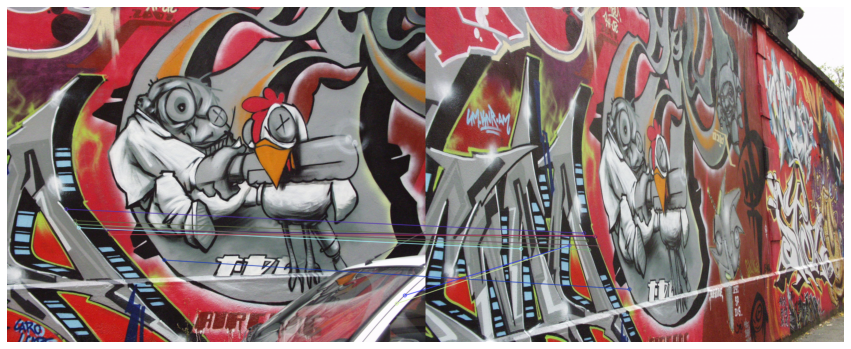

In [23]:
img1 = cv2.imread('img1.ppm')  
img2 = cv2.imread('img5.ppm') 



sift = cv2.SIFT_create(nOctaveLayers = 3,contrastThreshold = .1,edgeThreshold = 25,sigma = 1)

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

bf_match = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf_match.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

match_img = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:10], img2, flags=2)
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.show()

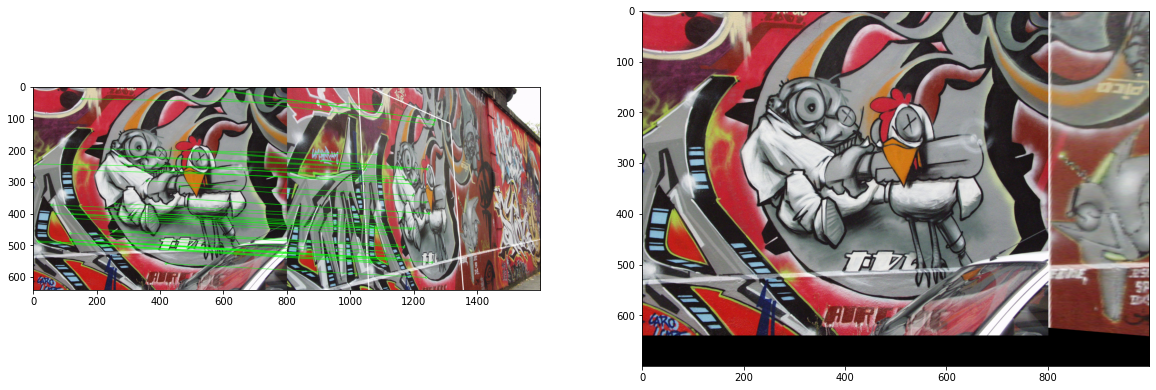

In [49]:
import numpy as np
import cv2 as cv

img1 = cv.imread('img1.ppm')
img2 = cv.imread('img5.ppm')

sift = cv.SIFT_create(nOctaveLayers = 3,contrastThreshold = .1,edgeThreshold = 25,sigma =1)

keyPoints1, descriptors1 = sift.detectAndCompute(img1, None)
keyPoints2, descriptors2 = sift.detectAndCompute(img2, None)

bf = cv.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

goodMatches = []
for m, n in matches:
    if m.distance < 0.86 * n.distance:
        goodMatches.append(m)
MIN_MATCH_COUNT = 10
if len(goodMatches) > MIN_MATCH_COUNT:
    sourcePoints = np.float32([keyPoints1[m.queryIdx].pt for m in goodMatches]).reshape(-1, 1, 2)
    destinationPoints = np.float32([keyPoints2[m.trainIdx].pt for m in goodMatches]).reshape(-1, 1, 2)
    M, mask = cv.findHomography(sourcePoints, destinationPoints, method=cv.RANSAC, ransacReprojThreshold=5.0)
    matchesMask = mask.ravel().tolist()
    h = img1.shape[0]
    w = img1.shape[1]
    corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    transformedCorners = cv.perspectiveTransform(corners, M)
    img2 = cv.polylines(img2, [np.int32(transformedCorners)], True, (255, 255, 255), 2, cv.LINE_AA)
else:
    matchesMask = None

drawParameters = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=matchesMask, flags=2)
result = cv.drawMatches(img1, keyPoints1, img2, keyPoints2, goodMatches, None, **drawParameters)


im4_warped = cv.warpPerspective(img2, np.linalg.pinv(M), (1000,700))
im4_warped[0:img1.shape[0], 0:img1.shape[1]] = img1

fig, ax = plt.subplots(1,2,figsize= (20,10))
ax[0].imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(im4_warped, cv.COLOR_BGR2RGB))
plt.show()

